min area: 1 max area: 26254
Bottom row sample areas: [   1    1    5   21 1494    1   47    3    1   29]


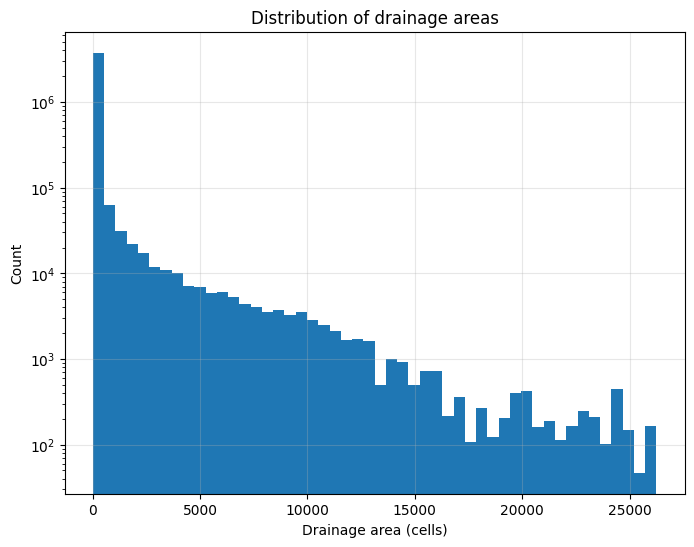


Number of basins: 999
Basin area range: 2 to 26254
Basin length range: 2 to 1999


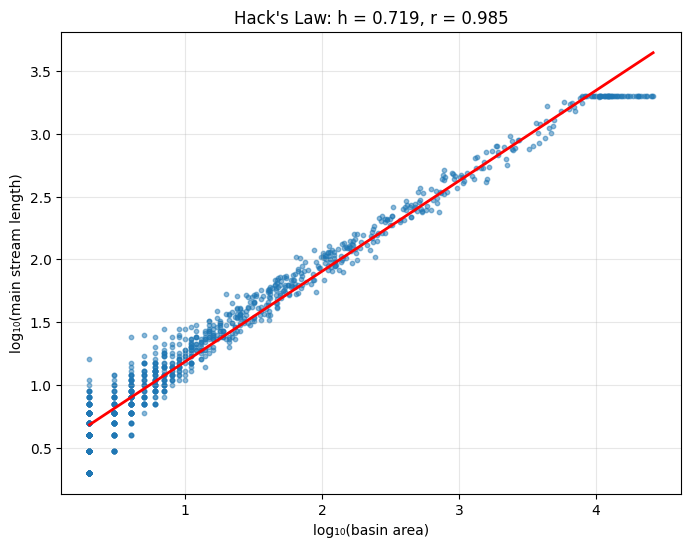

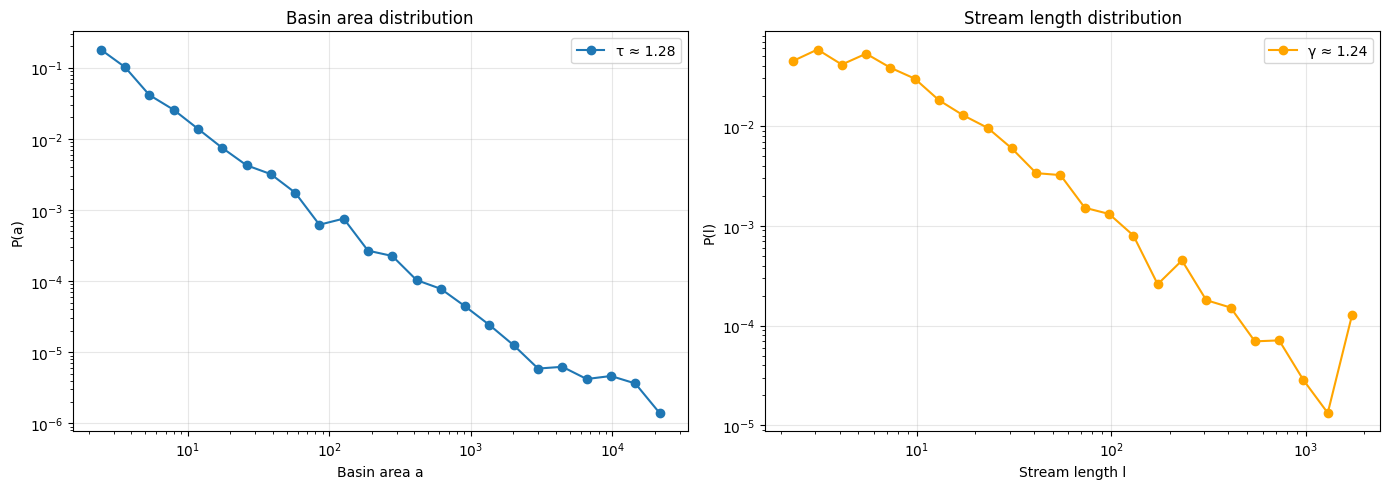


=== Scaling Relations ===
h (Hack exponent) = 0.719  (theory: 2/3 ≈ 0.667)
τ (area dist) = 1.282  (theory: 4/3 ≈ 1.333)
γ (length dist) = 1.238  (theory: 3/2 = 1.5)

Scaling relation: τ = 1 - h(1 - γ)
  LHS (measured τ): 1.282
  RHS (from h, γ):  1.171
  Difference: 0.111


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from collections import defaultdict, deque

# Parameters
Lx = 2000
Ly = 2000
seed = 42

# Initialize
np.random.seed(seed)
flow_dir = np.random.choice([-1, 1], size=(Ly, Lx))

# Build explicit downstream network
downstream = {}
for i in range(Ly):
    for j in range(Lx):
        if i == Ly - 1:
            downstream[(i, j)] = None  # outlet
        else:
            dj = flow_dir[i, j]
            j2 = (j + dj) % Lx
            i2 = i + 1
            downstream[(i, j)] = (i2, j2)

# Build upstream neighbors
upstream = defaultdict(list)
for i in range(Ly):
    for j in range(Lx):
        if i < Ly - 1:
            dj = flow_dir[i, j]
            j2 = (j + dj) % Lx
            i2 = i + 1
            upstream[(i2, j2)].append((i, j))

# ========================================
# OPTIMIZED: Compute area using topological order
# Start from outlets and work backward
# ========================================
area = {}
computed = set()

# Process using BFS from all outlets
queue = deque()
in_degree = {}

# Calculate in-degree (number of upstream cells)
for i in range(Ly):
    for j in range(Lx):
        in_degree[(i, j)] = len(upstream[(i, j)])
        if in_degree[(i, j)] == 0:  # No upstream cells
            area[(i, j)] = 1
            queue.append((i, j))
            computed.add((i, j))

# Process in topological order
while queue:
    current = queue.popleft()
    
    # Add this cell's area to downstream cell
    next_cell = downstream[current]
    if next_cell is not None:
        if next_cell not in area:
            area[next_cell] = 0
        area[next_cell] += area[current]
        
        # Check if all upstream cells of next_cell have been processed
        all_upstream_done = True
        for up_cell in upstream[next_cell]:
            if up_cell not in computed:
                all_upstream_done = False
                break
        
        if all_upstream_done and next_cell not in computed:
            if next_cell not in area:
                area[next_cell] = 1
            computed.add(next_cell)
            queue.append(next_cell)

# Make sure all outlet cells are initialized
for j in range(Lx):
    outlet = (Ly - 1, j)
    if outlet not in area:
        area[outlet] = 1

# Extract areas as array
area_array = np.zeros((Ly, Lx), dtype=int)
for i in range(Ly):
    for j in range(Lx):
        area_array[i, j] = area.get((i, j), 1)

print("min area:", area_array.min(), "max area:", area_array.max())
print("Bottom row sample areas:", area_array[Ly-1, :10])

plt.figure(figsize=(8, 6))
plt.hist(area_array.ravel(), bins=50)
plt.yscale('log')
plt.xlabel('Drainage area (cells)')
plt.ylabel('Count')
plt.title('Distribution of drainage areas')
plt.grid(True, alpha=0.3)
plt.show()

# ========================================
# OPTIMIZED: Compute path lengths
# ========================================
path_length = np.zeros((Ly, Lx), dtype=int)

# Bottom row has path length 0, work upward
for i in range(Ly - 2, -1, -1):
    for j in range(Lx):
        dj = flow_dir[i, j]
        j2 = (j + dj) % Lx
        i2 = i + 1
        path_length[i, j] = path_length[i2, j2] + 1

# ========================================
# Basin analysis
# ========================================
basin_areas = []
basin_lengths = []

for j in range(Lx):
    outlet = (Ly - 1, j)
    A = area_array[outlet]
    if A <= 1:
        continue
    basin_areas.append(A)
    
    # BFS to find max path length in this basin
    max_len = 0
    queue_basin = deque([outlet])
    visited = {outlet}
    
    while queue_basin:
        current = queue_basin.popleft()
        max_len = max(max_len, path_length[current])
        
        for upstream_cell in upstream[current]:
            if upstream_cell not in visited:
                visited.add(upstream_cell)
                queue_basin.append(upstream_cell)
    
    basin_lengths.append(max_len)

print(f"\nNumber of basins: {len(basin_areas)}")
if basin_areas:
    print(f"Basin area range: {min(basin_areas)} to {max(basin_areas)}")
    print(f"Basin length range: {min(basin_lengths)} to {max(basin_lengths)}")

# Hack's law
a = np.array(basin_areas, dtype=float)
l = np.array(basin_lengths, dtype=float)
log_a = np.log10(a)
log_l = np.log10(l)
slope, intercept, r, _, _ = linregress(log_a, log_l)

plt.figure(figsize=(8, 6))
plt.scatter(log_a, log_l, s=10, alpha=0.5)
xfit = np.linspace(log_a.min(), log_a.max(), 100)
plt.plot(xfit, intercept + slope * xfit, 'r-', lw=2)
plt.xlabel('log₁₀(basin area)')
plt.ylabel('log₁₀(main stream length)')
plt.title(f"Hack's Law: h = {slope:.3f}, r = {r:.3f}")
plt.grid(True, alpha=0.3)
plt.show()

# Area distribution
def fit_power_law(data, nbins=25):
    data = np.array(data)
    data = data[data > 0]
    bins = np.logspace(np.log10(data.min()), np.log10(data.max()), nbins)
    counts, edges = np.histogram(data, bins=bins)
    centers = np.sqrt(edges[:-1] * edges[1:])
    widths = np.diff(edges)
    density = counts / (counts.sum() * widths)
    mask = counts > 5
    if mask.sum() < 3:
        return centers, density, np.nan
    log_x = np.log10(centers[mask])
    log_P = np.log10(density[mask])
    slope, _, _, _, _ = linregress(log_x, log_P)
    return centers, density, slope

centers_a, Pa, tau = fit_power_law(basin_areas)
centers_l, Pl, gamma = fit_power_law(basin_lengths)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(centers_a, Pa, 'o-', label=f'τ ≈ {-tau:.2f}')
ax1.set_xlabel('Basin area a')
ax1.set_ylabel('P(a)')
ax1.set_title('Basin area distribution')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.loglog(centers_l, Pl, 'o-', color='orange', label=f'γ ≈ {-gamma:.2f}')
ax2.set_xlabel('Stream length l')
ax2.set_ylabel('P(l)')
ax2.set_title('Stream length distribution')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Scaling relation check
print(f"\n=== Scaling Relations ===")
print(f"h (Hack exponent) = {slope:.3f}  (theory: 2/3 ≈ 0.667)")
print(f"τ (area dist) = {-tau:.3f}  (theory: 4/3 ≈ 1.333)")
print(f"γ (length dist) = {-gamma:.3f}  (theory: 3/2 = 1.5)")
print(f"\nScaling relation: τ = 1 - h(1 - γ)")
print(f"  LHS (measured τ): {-tau:.3f}")
print(f"  RHS (from h, γ):  {1 - slope * (1 - (-gamma)):.3f}")
print(f"  Difference: {abs(-tau - (1 - slope * (1 - (-gamma)))):.3f}")

In [ ]:
# Add this after your existing area calculation:

# Extract only outlet (basin) areas
outlet_areas = [area[(Ly-1, j)] for j in range(Lx)]

# Create comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# All cells (your current plot)
ax1.hist(area_array.ravel(), bins=50)
ax1.set_yscale('log')
ax1.set_xlabel('Drainage area (cells)')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of ALL cell drainage areas')
ax1.grid(True, alpha=0.3)

# Only basin outlets
ax2.hist(outlet_areas, bins=50, color='orange')
ax2.set_yscale('log')
ax2.set_xlabel('Basin area (cells)')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of BASIN areas (outlets only)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nOutlet statistics:")
print(f"Mean basin area: {np.mean(outlet_areas):.1f}")
print(f"Median basin area: {np.median(outlet_areas):.1f}")
print(f"Std dev: {np.std(outlet_areas):.1f}")

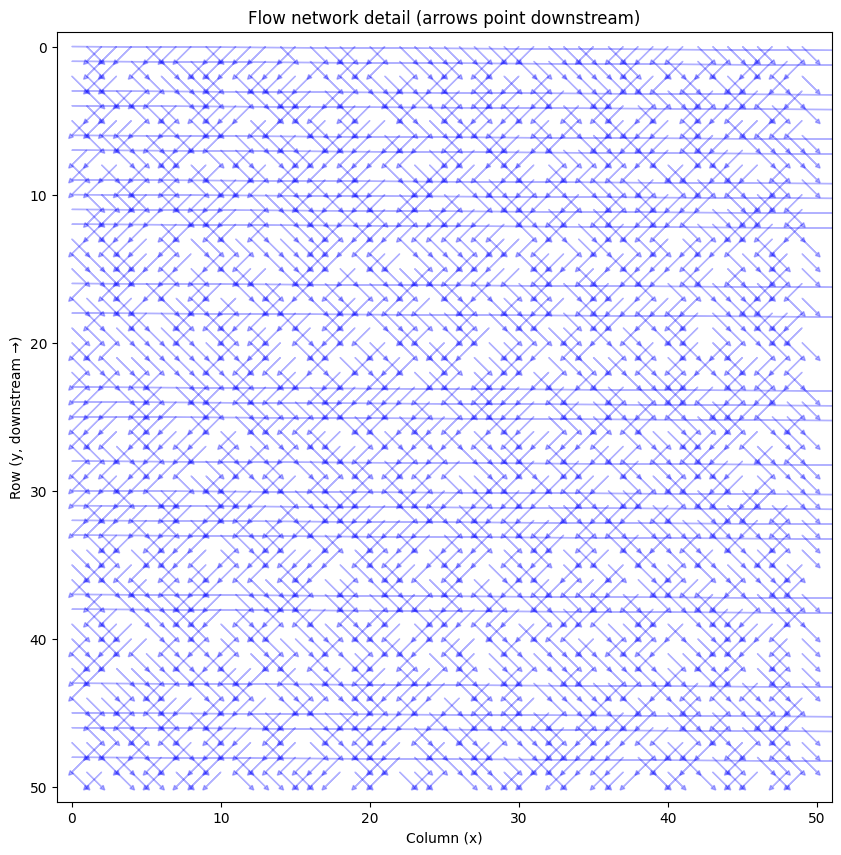

In [18]:
# Visualize a small region
fig, ax = plt.subplots(figsize=(10, 10))
i_start, i_end = 0, 50
j_start, j_end = 0, 50

for i in range(i_start, i_end):
    for j in range(j_start, j_end):
        if downstream[(i, j)] is not None:
            i2, j2 = downstream[(i, j)]
            ax.arrow(j, i, j2-j, i2-i, head_width=0.3, 
                    head_length=0.3, fc='blue', ec='blue', alpha=0.3)

ax.set_xlim(j_start-1, j_end+1)
ax.set_ylim(i_end+1, i_start-1)  # invert y for downstream = down
ax.set_xlabel('Column (x)')
ax.set_ylabel('Row (y, downstream →)')
ax.set_title('Flow network detail (arrows point downstream)')
plt.show()